# Baseline

## Description

A Convolutional Neural Network (CNN/ConvNet) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. It is most commonly applied to analyze visual imagery. We will be using CNN for our multi-label classification task. In the baseline implementation of CNN, we will use only one Conv layer, followed by ReLU non-linear activation, a Maxpool layer and an output Linear layer.

## Architecture
![label_ss](./images/cnn_baseline.png)

## Implementation

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torchvision
import torchvision.transforms as transforms
import tqdm
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
from src.dataset import *
from src.utils import *
import torch.optim as optim

import matplotlib
from torch.utils.data import DataLoader

### Model definition

In [3]:
class cnn_baseline(nn.Module):
    def __init__(self):

        super(cnn_baseline, self).__init__()

        # CL1: 3 x 144 x 256 --> 50 x 144 x 256
        self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding='same')

        # MP1: 50 x 144 x 256 --> 50 x 72 x 128 
        self.pool1 = nn.MaxPool2d(2, 2)

        # LL1:   50 x 72 x 128  = 460800 -->  6
        self.linear1 = nn.Linear(460800, 6)

    def forward(self, x):

        # CL1: 3 x 144 x 256 --> 50 x 144 x 256
        x = self.conv1(x)
        x = F.relu(x)

        # MP1: 50 x 144 x 256 --> 50 x 72 x 128 
        x = self.pool1(x)

        # LL1:   50 x 72 x 128  = 460800 -->  6
        x = x.view(-1, 460800)
        x = self.linear1(x)

        return x

In [4]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print("Training")
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_error = 0.0
    for i, data in tqdm(
        enumerate(dataloader), total=int(len(train_data) / dataloader.batch_size)
    ):
        
        counter += 1
        data, target = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.detach().item()
        error = get_error( outputs.detach() , target, batch_size)
        train_running_error += error
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

        
    train_loss = train_running_loss / counter
    total_error = train_running_error/counter
    return train_loss, total_error

In [5]:
def validate(model, dataloader, criterion, val_data, device):
    print("Validating")
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_error = 0.0
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader), total=int(len(val_data) / dataloader.batch_size)
        ):
            counter += 1
            data, target = data["image"].to(device), data["label"].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            error = get_error( outputs, target, batch_size)
            val_running_error += error
        val_loss = val_running_loss / counter
        val_error = val_running_error / counter
    return val_loss, val_error

### Model instantiation

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn_baseline()
model = model.to(device)
display_num_param(model)
print(model)
lr = 0.0001
epochs = 10
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()

There are 2766206 (2.77 million) parameters in this neural network
cnn_baseline(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=460800, out_features=6, bias=True)
)


### Data Loading

In [7]:
# train dataset
train_data = ImageDataset(train=True)
# validation dataset
valid_data = ImageDataset(train=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

Number of training images: 2065
Number of test images: 365


### Train

In [8]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, total_epoch_error = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss, valid_epoch_error = validate(model, valid_loader, criterion, valid_data, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print("Train Error: ", total_epoch_error)
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    print(f"Val Error: ", valid_epoch_error)
    

Epoch 1 of 10
Training


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
65it [00:05, 11.42it/s]                                                                                                


Validating


12it [00:00, 18.07it/s]                                                                                                


Train Loss: 0.5015
Train Error:  22.10737247306567
Val Loss: 0.6974
Val Error:  29.64409825702508
Epoch 2 of 10
Training


65it [00:04, 15.85it/s]                                                                                                


Validating


12it [00:00, 17.04it/s]                                                                                                


Train Loss: 0.3005
Train Error:  12.219551652669907
Val Loss: 0.7242
Val Error:  28.906250993410747
Epoch 3 of 10
Training


65it [00:04, 15.51it/s]                                                                                                


Validating


12it [00:00, 13.93it/s]                                                                                                


Train Loss: 0.2233
Train Error:  8.373397680429312
Val Loss: 0.6683
Val Error:  27.951389799515407
Epoch 4 of 10
Training


65it [00:09,  7.21it/s]                                                                                                


Validating


12it [00:01, 10.17it/s]                                                                                                


Train Loss: 0.1678
Train Error:  5.528846328648237
Val Loss: 0.8107
Val Error:  28.645834202567737
Epoch 5 of 10
Training


65it [00:11,  5.85it/s]                                                                                                


Validating


12it [00:01,  9.00it/s]                                                                                                


Train Loss: 0.1335
Train Error:  4.006410380108998
Val Loss: 0.7739
Val Error:  25.781250620881718
Epoch 6 of 10
Training


65it [00:11,  5.82it/s]                                                                                                


Validating


12it [00:01,  9.09it/s]                                                                                                


Train Loss: 0.1081
Train Error:  2.860577006179553
Val Loss: 0.8122
Val Error:  27.821181093653042
Epoch 7 of 10
Training


65it [00:11,  5.73it/s]                                                                                                


Validating


12it [00:01,  7.63it/s]                                                                                                


Train Loss: 0.0917
Train Error:  2.3717949403306613
Val Loss: 0.8349
Val Error:  25.86805646618207
Epoch 8 of 10
Training


65it [00:11,  5.79it/s]                                                                                                


Validating


12it [00:01,  9.04it/s]                                                                                                


Train Loss: 0.0750
Train Error:  1.6907051750100577
Val Loss: 0.8605
Val Error:  27.647570396463077
Epoch 9 of 10
Training


65it [00:11,  5.62it/s]                                                                                                


Validating


12it [00:01,  8.29it/s]                                                                                                


Train Loss: 0.0649
Train Error:  1.4102564422556987
Val Loss: 0.9595
Val Error:  25.911458830038708
Epoch 10 of 10
Training


65it [00:11,  5.76it/s]                                                                                                


Validating


12it [00:02,  5.75it/s]                                                                                                

Train Loss: 0.0554
Train Error:  1.0737179721204133
Val Loss: 0.9253
Val Error:  26.34548706312974


### Test

In [9]:
actors = np.array(CLASSES)
print('actors: ', actors)
# prepare the test dataset and dataloader
test_data = ImageDataset(train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']
Number of test images: 365


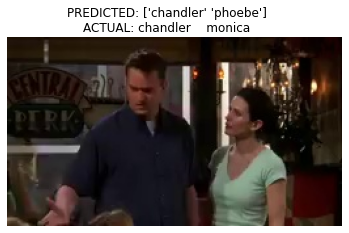

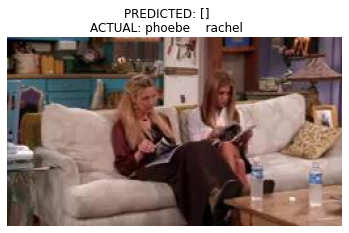

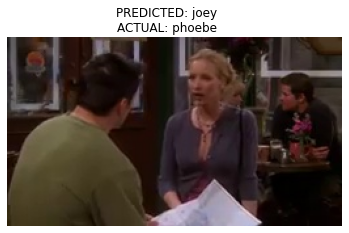

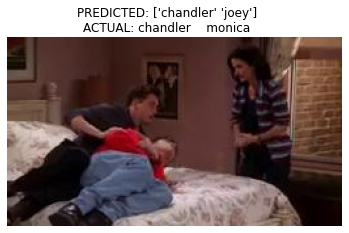

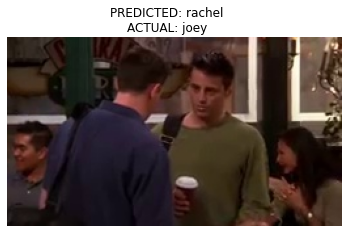

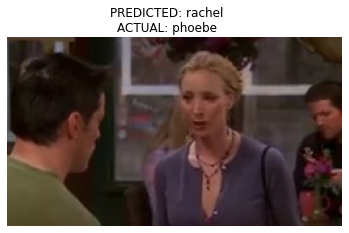

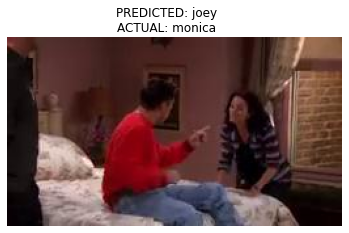

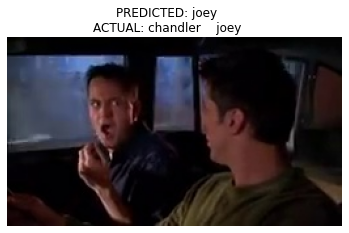

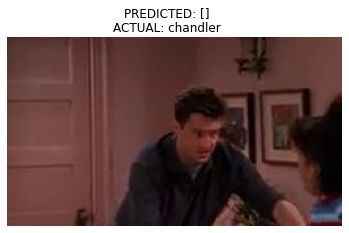

Test Error:  27.793040920744886


In [10]:
model.eval()
test_running_error = 0.0
output_list= []
target_list = []
for counter, data in enumerate(test_loader):
    
    image, target = data["image"].to(device), data["label"]
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
    # get the predictions by passing the image through the model
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    lab = torch.where(outputs>=0.5,1,0)[0]
    pred = torch.where(lab==1)
    error = get_error( outputs, target, 1)
    output_list.append(outputs.numpy())
    target_list.append(target.numpy())
    
    test_running_error += error
    
    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]}    "

    if 10< counter < 20:
        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()
    
test_error = test_running_error / counter
print(f"Test Error: ", test_error)

out = np.array(output_list).squeeze(axis=1)
tar = np.array(target_list).squeeze(axis=1)

In [11]:
f1 = get_f1_score(tar, out)
precision = get_precision_score(tar, out)
recall = get_recall_score(tar, out)
print("f1 score: ", f1)
print('Precision: ', precision)
print('Recall: ', recall)

f1 score:  0.30050228310502286
Precision:  0.3470319634703196
Recall:  0.3203196347031963


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results

For a CNN with one Conv layer followed by a Max-Pool layer and a linear output layer, the below are the results after training for 10 epocs:

* Train Loss: 0.0554
* Train Error:  1.0737179721204133
* Val Loss: 0.9253
* Val Error:  26.34548706312974
* We observe that the Train Loss and Train error decreases after each epoch. However, the Validation error may increase or decrease after each epoch (overfitting).
* Test Error:  27.793040920744886
* F1 score:  0.30050228310502286
* Precision:  0.3470319634703196
* Recall:  0.3203196347031963
* The Test error is 27.793% and we have a F1 score of 0.3005
* Learnable Parameters: 2.77 million

## Discussion

* The model overfits the data causing fluctuation in the Validation error. If the dataset size is increased or the number of ConvNet layers are increased, it may actually capture more features and improve our results.
* A reason for overfitting could be the lack of regularization. One could add dropouts or apply image augmentation techniques to prevent the model from overfitting.
* 


We try to address some of the above concerns in the CNN improvement discussed next.